In [1]:
%load_ext autoreload
%autoreload 2

In [15]:
import numpy as onp
from scipy.optimize import minimize
import pandas as pd
import jax.numpy as np
from jax.config import config
from jax import ops
from tqdm import tqdm
from gzbuilder_analysis.fitting.optimizer import render_comps, psf_conv, Optimizer, get_nnlf
from gzbuilder_analysis.fitting.misc import get_luminosity_keys, \
    remove_zero_brightness_components, lower_spiral_indices, correct_spirals

config.update("jax_enable_x64", True)

In [3]:
fitting_metadata = pd.read_pickle('lib/fitting_metadata.pkl')

In [4]:
subject_id = 20902040
fm = fitting_metadata.loc[subject_id]
agg_res = pd.read_pickle('output_files/aggregation_results/{}.pkl.gz'.format(subject_id))

In [5]:
o = Optimizer(agg_res, *fm[['psf', 'galaxy_data', 'sigma_image']], oversample_n=5)

/Users/tlingard/anaconda3/lib/python3.6/site-packages/jax/lib/xla_bridge.py:122: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [7]:
def _f(p, optimizer, keys):
    return onp.array(optimizer(p, keys).block_until_ready(), dtype=np.float64)

def _j(p, optimizer, keys):
    return onp.array(optimizer.jac(p, keys).block_until_ready(), dtype=np.float64)

L_keys = get_luminosity_keys(o.model)
with tqdm(desc='Fitting') as bar:
    cb = lambda *a, **k: bar.update(1)
    res = minimize(
        _f,
        onp.array([o.model_[k] for k in L_keys]),
        jac=_j,
        args=(o, L_keys),
        callback=cb,
        bounds=onp.array([o.lims_[k] for k in L_keys]),
    )
res

Fitting: 24it [00:18,  1.32it/s]


      fun: array(109154.97515366)
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 5.01668688e-05,  8.15639826e+03,  6.02343120e-02,  6.65386905e-02,
       -1.52097181e-02])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 27
      nit: 24
   status: 0
  success: True
        x: array([1.32892217e+03, 0.00000000e+00, 1.18347320e-01, 5.02406913e-01,
       5.82483466e-01])

In [8]:
for k, v in zip(L_keys, res['x']):
    print('{:<6} {:<10}: {:.2f} -> {:.2f} ({:+.5f})'.format(*k, o.model_[k],  v, o.model_[k] - v))
    o[k] = v

disk   L         : 2955.91 -> 1328.92 (+1626.98606)
bulge  frac      : 0.05 -> 0.00 (+0.05000)
bar    frac      : 0.10 -> 0.12 (-0.01835)
spiral I.0       : 0.10 -> 0.50 (-0.40241)
spiral I.1       : 0.10 -> 0.58 (-0.48248)


In [9]:
float(o(res['x'], L_keys)), float(o(onp.array([o.model_[k] for k in L_keys]), L_keys)), res['fun']

(109154.97515366087, 109154.97515366087, array(109154.97515366))

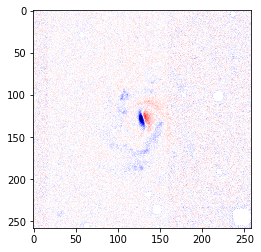

In [10]:
comps = render_comps(o.model_, 'bulge' in o.model, 'bar' in o.model, o.n_spirals, o.target.shape, 5, o.base_roll)
d = ops.index_update(psf_conv(sum(comps.values()), o.psf) - o.target, o.mask, np.nan)
lim = np.nanmax(np.abs(d))
plt.imshow(d, vmin=-lim, vmax=lim, cmap='seismic')

In [11]:
with tqdm(desc='Fitting') as bar:
    cb = lambda *a, **k: bar.update(1)
    res_full = minimize(
        _f,
        onp.array([o.model_[k] for k in o.keys]),
        jac=_j,
        args=(o, o.keys),
        callback=cb,
        bounds=onp.array([o.lims_[k0][k1] for k0, k1 in o.keys]),
        options=dict(maxiter=50)
    )
res_full

Fitting: 50it [01:58,  2.37s/it]


      fun: array(99465.03778475)
 hess_inv: <31x31 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 1.30758678e+02, -1.38456818e+02,  6.36474687e+02,  4.95400348e+02,
       -1.22890775e+02,  3.01359703e+00, -1.33172214e+03,  4.47033570e+00,
        3.94196330e+02, -2.74013215e+03,  3.04670998e+02, -9.59335419e+02,
       -4.11289904e+02,  4.71950833e+01, -5.09475076e+03,  2.87574153e+02,
        0.00000000e+00,  4.28899227e+01,  1.03656432e+02,  5.24322776e+02,
        1.16968214e+02,  1.20644879e+02, -8.30226420e+01,  4.54191703e+02,
       -1.03118119e+02,  7.00025857e+02,  7.20231727e+01, -1.01772419e+01,
       -3.87693445e+01, -2.79748572e+01, -3.78556440e+01])
  message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
     nfev: 60
      nit: 50
   status: 1
  success: False
        x: array([ 1.28280908e+02,  1.28615766e+02,  7.91642651e-01,  2.95023914e+00,
        4.00463010e+01,  1.32891827e+03,  6.11229937e-01,  2.97004844e+00,
        1.09849488e-01,  4.65084172e-

In [12]:
for k, v in zip(o.keys, res_full['x']):
    o[k] = v

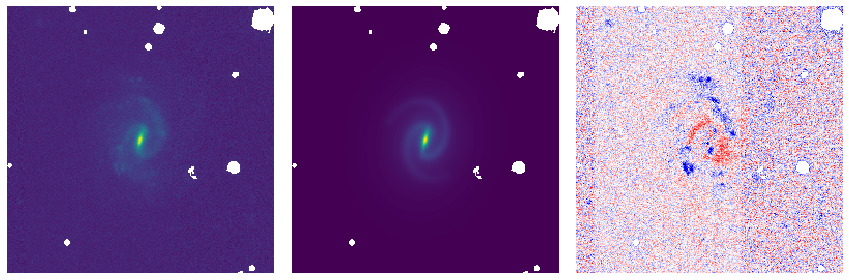

In [13]:
comps = render_comps(o.model_, 'bulge' in o.model, 'bar' in o.model, o.n_spirals, o.target.shape, 5, o.base_roll)
d = ops.index_update(psf_conv(sum(comps.values()), o.psf) - o.target, o.mask, np.nan)
lim = np.nanmax(np.abs(d))
f, ax = plt.subplots(ncols=3, figsize=(12, 4))
ax[0].imshow(ops.index_update(o.target, o.mask, np.nan), origin='lower')
ax[1].imshow(ops.index_update(psf_conv(sum(comps.values()), o.psf), o.mask, np.nan), origin='lower')
ax[2].imshow(d, vmin=-lim, vmax=lim, cmap='seismic', origin='lower')
[a.axis('off') for a in ax];
plt.tight_layout()

In [16]:
final_model = pd.Series({
    **o.model_,
    **{k: v for k, v in zip(o.keys, res_full['x'])}
})

# remove components with zero brightness
final_model = remove_zero_brightness_components(final_model)

# lower the indices of spirals where possible
final_model = lower_spiral_indices(final_model)

# correct the spirals in this model for the new disk
final_model = correct_spirals(final_model, o.base_roll)

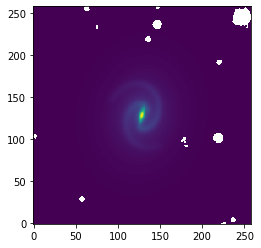

In [18]:
comps2 = render_comps(
    final_model.to_dict(),
    'bulge' in final_model,
    'bar' in final_model,
    len(final_model.get('spiral', []))//6,
    fm['galaxy_data'].shape,
    5,
    final_model[('disk', 'roll')]
)
plt.imshow(ops.index_update(psf_conv(sum(comps2.values()), o.psf), o.mask, np.nan), origin='lower')

In [19]:
from IPython.display import Latex

In [20]:
chisq = float(np.sum((d[~o.mask] / o.sigma[~o.mask])**2) / (~o.mask).sum())
Latex(r'$\chi_\nu = {:.3f}$'.format(chisq))

<IPython.core.display.Latex object>

In [21]:
f = lambda : get_nnlf(
    o.model_, 'bulge' in o.model, 'bar' in o.model, o.n_spirals, o.target.shape, 5, o.base_roll,
    o.model_, o.model_err_, o.psf, o.mask, o.target, o.sigma
)

In [23]:
%timeit f().block_until_ready()

254 ms ± 70.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
